# [실습2] 비결정론적 시뮬레이션 환경을 활용한 Q-Learning 실습

이번 실습에서는 간단한 비결정론적 시뮬레이션 환경을 활용하여 Q-Learning을 직접 구현해보도록 하겠습니다. <br>

비결정론적인 환경이란, 에이전트가 특정한 행동을 취했을 때 그에 따른 다음 상태와 보상이 **하나로 결정되지 않고** 확률에 따라 정해지는 환경을 의미합니다.

### 라이브러리 불러오기

필요한 라이브러리를 불러옵니다.

In [1]:
# 필요한 라이브러리를 불러옵니다.
import gymnasium as gym
import numpy as np
import pandas as pd

# 학습을 완료한 에이전트를 시각화하는데 필요한 라이브러리를 불러옵니다
from IPython import display # IPython 라이브러리에 있는 display 모듈을 사용합니다.
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Epsilon-Greedy 를 적용하기 위한 random 모듈을 불러옵니다.
import random

## 1. FrozenLake 시뮬레이션 환경

미끄러운 얼음 호수 위에서 정해진 위치에 Agent와 목적지가 주어지면 목적지까지 Agent를 이동시키는 간단한 시뮬레이션 환경입니다. <br>
얼음 호수는 미끄럽기 때문에 걷고자 하는 방향으로 나아가기 쉽지 않고, 때로는 의도치 않은 방향으로 이동할 수 있습니다. 이 성질을 활용해 비결정론적 시뮬레이션 환경을 구현할 수 있습니다.

![FrozenLake](./images/FrozenLake_v1.gif)


Environment는 다음과 같이 정의됩니다.

- 가능한 모든 상태 집합 S = Agent의 위치 (4x4 격자)
- 가능한 행동 집합 A = {상, 하, 좌, 우}
- 전이 함수 P: 행동을 그대로 수행할 가능성: 1/3, **의도한 방향의 수직인 방향으로 이동할 가능성(미끄러질 가능성): 양 방향으로 각각 1/3**
- 보상 함수 R: 목적지에 도착하면 1, 그 외의 경우 0 (구멍에 빠진 경우 포함)
- 감가율 γ (gamma) = 0.99 (FrozenLake 환경의 자체 설정이 아니라, 임의로 설정한 값입니다)

Taxi-v3 환경과 달리 Slippery Frozen Lake 환경에서는 전이 함수 P가 **결정론적이지 않습니다.** (같은 환경에서 같은 행동을 취하더라도, 확률에 따라 다른 상태로 이동할 수 있습니다.)

FrozenLake 환경은 Taxi-v3 환경과 달리 **목적지에 도착했을 때만 보상 혹은 페널티가 주어지는** 환경입니다. 


FrozenLake-v1 환경을 불러옵니다.

In [2]:
# 'FrozenLake-v1' 환경을 생성합니다.
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

In [3]:
# 학습 과정에서 생성할 Q-Table의 크기를 확인합니다. Envirionment의 상태(State)의 개수는 16개이며, Action의 개수는 4개입니다.
print([env.observation_space.n, env.action_space.n])

[16, 4]


## 2. 학습 환경 구축

Agent가 이동하는 과정에서 주어지는 보상 혹은 페널티가 사라짐에 따라 Agent가 환경을 탐험할 요인이 상대적으로 줄어들게 됩니다. 

이러한 환경에서 탐험을 촉진하기 위해 Epsilon-greedy를 적용한 Q-Learning을 구현해 보겠습니다.

먼저 학습 파라미터를 설정합니다.

In [4]:
# 학습 파라미터를 설정합니다.
learning_rate = 0.1 # 학습률 eta
gamma = 0.99 # 감가율
num_episodes = 150000 # 에피소드 수
max_steps = 100 # 각 에피소드 별 최대 스텝 수

# Epsilon-Greedy 알고리즘을 위한 학습 파라미터를 설정합니다. 
# 시작에는 Q 함수를 무시한 채 탐험할 확률이 높으나(epsilon_start), 점점 정해진 감가율 (epsilon_decay) 에 따라 Q 함수를 무시한 채 랜덤한 행동을 선택할 확률을 하한선까지(epsilon_end) 낮춥니다.
epsilon_start = 0.5
epsilon_end = 0.001
epsilon_decay = 0.005 # 입실론 감가율

아래 코드는 Epsilon-greedy를 **적용하지 않은 학습 함수**입니다. 이 함수로 학습한 Q-Table을 차후 Epsilon-greedy를 적용한 학습을 거친 Q-Table과 비교하여 차이를 확인해 볼 것입니다.

In [5]:
# 환경과 학습 파라미터를 입력 받으면 Q-Table을 학습하여 리턴하는 함수를 정의합니다.
def Q_learning(env, gamma, learning_rate, num_episodes, max_steps, Q_table = None):
    
    # 파라미터로 Q_table이 주어질 경우 그를 바탕으로 학습을 진행합니다.
    if Q_table is None: 
        Q = np.ones([env.observation_space.n, env.action_space.n])
    else:
        Q = Q_table
    
    # 에피소드별 총 보상과 스텝을 저장할 리스트를 생성합니다.
    rList = []
    for i in range(num_episodes):
    # 환경을 초기화하고 첫 번째 새로운 관찰을 얻습니다.
        state = env.reset()[0]
        rAll = 0
        done = False
        # Q-Table 학습 알고리즘
        for j in range(max_steps):
            # 현재 상태(state)를 바탕으로 Q-Table에서 행동을 결정합니다.
            action = np.argmax(Q[state,:])
            
            # 환경에서 새로운 상태와 보상을 얻습니다.
            next_state, reward, done, _, _ = env.step(action)
            
            # 오차를 계산합니다. (y = 감가율)
            error = reward + gamma * np.max(Q[next_state,:]) - Q[state,action]

            # 오차를 기반으로 Q-Table을 업데이트합니다.
            Q[state,action] = Q[state,action] + learning_rate * error
            rAll += reward
            state = next_state
            if done == True:
                break
        
        # 에피소드별 총 보상을 리스트에 저장합니다.
        rList.append(rAll)      
    
    # 학습된 Q-Table을 리턴합니다.
    return Q, rList

### [TODO] Epsilon-greedy 기법을 적용한 학습 함수를 정의합니다.
- 위의 함수를 참고하여, Epsilon-greedy 기법을 적용한 학습 함수를 정의합니다.

In [6]:
# 환경과 학습 파라미터를 입력 받으면 Q-Table을 학습하여 리턴하는 함수를 정의합니다.
def Q_learning_epsilon(env, gamma, learning_rate, num_episodes, max_steps, Q_table = None, epsilon_start = 0.5, epsilon_end = 0.01, epsilon_decay = 0.005):

    # epsilon 값을 초기화 합니다.
    epsilon = epsilon_start
    
    # 파라미터로 Q_table이 주어질 경우 그를 바탕으로 학습을 진행합니다.
    if Q_table is None:
        # Q-Table을 초기화합니다.
        Q = np.ones([env.observation_space.n, env.action_space.n])
    else:
        Q = Q_table
    
    # 에피소드별 총 보상과 스텝을 저장할 리스트를 생성합니다.
    rList = []
    for i in range(num_episodes):
        # TODO: Epsilon-Greedy를 위한 epsilon 값을 계산합니다.
        # epsilon 값이 epsilon_end 보다 작아지지 않도록 합니다. 
        # Hint: max() 함수를 사용하여 두 값 중 큰 값을 선택할 수 있습니다.
        epsilon = max(epsilon, epsilon_end) # None을 올바른 코드로 대체해 주세요.

        # 환경을 초기화하고 첫 번째 새로운 관찰을 얻습니다.
        state = env.reset()[0]
        rAll = 0
        done = False
        # Q-Table 학습 알고리즘
        for j in range(max_steps):
            # TODO: epsilon 확률로 랜덤한 액션을 선택하고, 그렇지 않은 경우 Q-Table을 바탕으로 액션을 선택합니다.
            # Hint. random.random()을 사용하여 0~1 사이의 랜덤한 값을 생성할 수 있습니다.
            # condition = None # None을 올바른 조건으로 대체해주세요.
            if random.random() > epsilon:
                # TODO: 현재 상태(state)를 바탕으로 Q-Table에서 행동을 결정해서 action 변수에 저장합니다.
                # Hint: Q[S,:]는 현재 상태가 S일 때 각 행동에 대한 Q 값을 담고 있는 list를 나타냅니다.
                action = np.argmax(Q[state,:]) # None을 올바른 코드로 대체해 주세요.
            else:
                # random 값이 epsilon보다 작을 경우 : 랜덤하게 action을 선정합니다.
                action = env.action_space.sample()
            
            # 환경에서 새로운 상태와 보상을 얻습니다.
            next_state, reward, done, _, _ = env.step(action)
            
            # TODO: 오차를 계산해서 error 변수에 저장합니다. (gamma = 감가율)
            # Hint: 오차 = 보상 + 감가율 * (다음 상태에서의 최대 Q 값) - (현재 상태에서의 Q 값)
            error = reward + gamma * np.max(Q[next_state,:]) - Q[state,action] # None을 올바른 코드로 대체해 주세요.

            # TODO: 오차(error)를 기반으로 Q-Table을 업데이트합니다.
            # Hint: Q[S,A] ← Q[S,A] + 학습률 * 오차
            Q[state,action] = Q[state,action] + learning_rate * error # None을 올바른 코드로 대체해 주세요.
            rAll += reward
            state = next_state
            if done == True:
                break

        # TODO: Epsilon 값을 업데이트하는 코드를 짜주세요
        # Hint. epsilon ← epsilon * (1 - epsilon 감가율)
        epsilon *= (1 - epsilon_decay) # None을 올바른 코드로 대체해 주세요.
        
        # 에피소드별 총 보상을 리스트에 저장합니다.
        rList.append(rAll)      
    
    # 학습된 Q-Table을 리턴합니다.
    return Q, rList

## 3. 학습 진행

학습을 진행합니다. 학습에는 약 2분이 소요됩니다.

In [7]:
# Epsilon-greedy 를 적용하지 않은 경우 (약 20초 소요)
Q, rList = Q_learning(env, gamma, learning_rate, num_episodes, max_steps)

In [8]:
# Epsilon-greedy 를 적용한 경우 (약 2분 소요)
Q_ep, rList_ep = Q_learning_epsilon(env, gamma, learning_rate, num_episodes, max_steps, epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)

rList 리스트에는 각 에피소드에서 얻은 reward가 저장됩니다. 이를 통해 학습이 진행됨에 따라 얻는 reward가 어떻게 변화하는지 확인할 수 있습니다.

rList를 시각화 해봅시다. 이때, 100 episode 단위로 평균을 계산하여 시각화합니다.

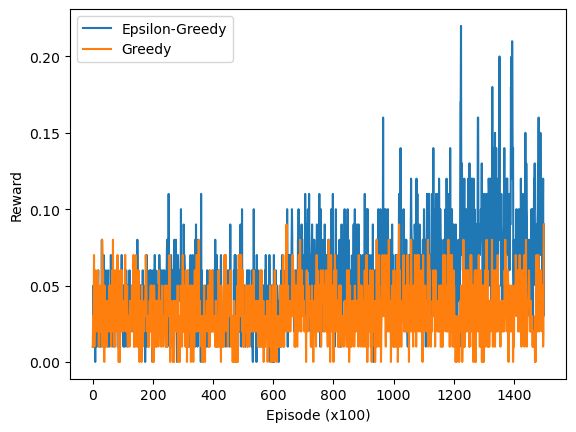

In [9]:
# rList를 시각화합니다.
# 100개 episode 단위로 평균을 계산합니다.
rList_100 = []
for i in range(0, len(rList), 100):
    rList_100.append(sum(rList[i:i+100])/100)

rList_ep_100 = []
for i in range(0, len(rList_ep), 100):
    rList_ep_100.append(sum(rList_ep[i:i+100])/100)

plt.plot(rList_ep_100)
plt.plot(rList_100)
plt.xlabel('Episode (x100)')
plt.ylabel('Reward')
plt.legend(['Epsilon-Greedy', 'Greedy'])
plt.show()

Epsilon-greedy를 적용한 Agent는 어느 순간부터 Reward의 평균이 증가하는 추세를 보일 것입니다. 

## 4. 결과 시각화

학습 완료한 Q-Table을 출력하는 visualize_Q 함수를 정의합니다.

In [10]:
def visualize_Q(Q):
    dirs = ['◁','▽','▷','△']
    for row in range(4):
        txt = ''
        for col in range(4):
            # 각 위치에서의 Maximum Q-value의 방향 출력
            txt += dirs[np.argmax(Q[row*4+col,:])]
        print(txt)

Epsilon-greedy 기법을 적용한 학습 함수를 통해 학습한 Q-Table과, 적용하지 않은 학습 함수를 통해 학습한 Q-Table을 비교해봅시다.

In [11]:
visualize_Q(Q)

▷▷▷▽
▽◁▽◁
▷▷▽◁
◁△▽◁


In [12]:
visualize_Q(Q_ep)

▷▷▽◁
▽◁▽◁
△▽◁◁
◁▷▷◁


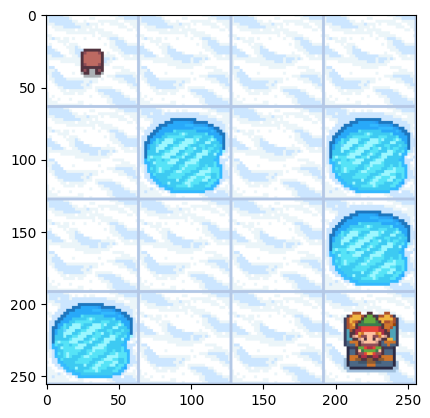

Q-Table 시각화 결과만 보면 Epsilon-greedy를 적용하지 않은 모델이 더 직관적인 것 처럼 보입니다. <br>
하지만, 전이 함수의 특징을 생각해보면 Q-Table의 시각화 결과를 그대로 따를 경우 미끄러져 딴 길로 새거나 구멍에 빠질 확률이 오히려 높음을 알 수 있습니다.
- 전이 함수 P: 행동을 그대로 수행할 가능성: 1/3, **의도한 방향의 수직인 방향으로 이동할 가능성(미끄러질 가능성): 양 방향으로 각각 1/3**

결과를 시각화하기 위해, 입력 받은 Q-Table을 적용한 Agent를 정해진 환경에서 시뮬레이팅 하는 함수를 정의합니다.

In [13]:
def simulate_Q(Q):
    # 테스트 및 시각화를 위해 시각화 가능한 새로운 환경을 생성합니다.
    env_test = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array')
    test_seed = 42

    state = env_test.reset(seed=test_seed)[0]

    # 초기 상태 렌더링
    screen = env_test.render()
    screen_queue = [screen]

    # 최대 100 step까지 시각화합니다.
    for i in range(100):
        action = np.argmax(Q[state,:])
        state, reward, done, truncated, info = env_test.step(action)
        screen = env_test.render()
        display.clear_output(wait=True)
        screen_queue.append(screen)    
        if done:        
            print("{} timesteps 만에 종료되었습니다.".format(i+1))
            break

    # env_test를 닫습니다.
    env_test.close()

    # 시뮬레이션 결과를 시각화하기 위한 정보를 리턴합니다.
    return screen_queue   

Epsilon-greedy를 적용하지 않은 학습 함수를 통해 학습한 Q-Table을 적용한 Agent의 시뮬레이션을 진행합니다.

In [14]:
screen_queue = simulate_Q(Q)

4 timesteps 만에 종료되었습니다.


시뮬레이션 결과를 시각화합니다.

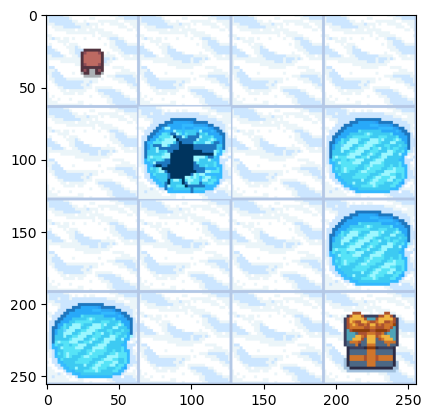

In [15]:
fig = plt.figure()
ims = []
for i in range(len(screen_queue)):
    im = plt.imshow(screen_queue[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat_delay=1000)
HTML(ani.to_jshtml())

다음으로, Epsilon-greedy를 적용한 함수를 통해 학습한 Q-Table을 적용한 Agent의 시뮬레이션 결과를 시각화합니다.

비결정론적인 환경 특성상, 간혹 목적지에 도달하지 못하는 경우도 있습니다. 그럴 경우 아래의 코드 블럭을 다시 실행해주세요.

4 timesteps 만에 종료되었습니다.


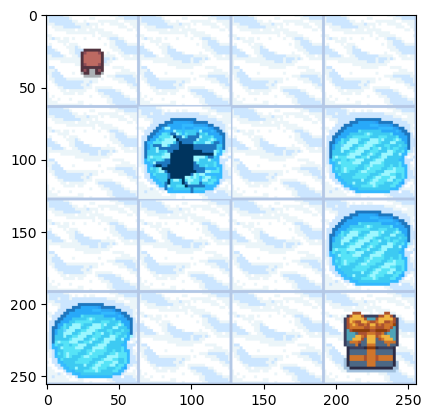

In [17]:
screen_queue_ep = simulate_Q(Q_ep)

# Agent의 경로를 시각화합니다.

fig = plt.figure()
ims = []
for i in range(len(screen_queue_ep)):
    im = plt.imshow(screen_queue_ep[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, 
                                repeat_delay=1000)
HTML(ani.to_jshtml())

In [18]:
# 애니메이션을 gif로 저장합니다.
ani.save('FrozenLake-v1.gif', writer='Pillow', fps=2)

MovieWriter Pillow unavailable; using Pillow instead.


### 결과 제출

- 아래 코드를 실행하여 학습을 완료한 Q-Table을 csv 파일로 생성한 뒤, 우측 상단에 있는 보라색 `제출` 버튼을 눌러 제출해주세요.
- 채점 환경에서 해당 Q-Table을 적용한 Agent가 목적을 달성하면 성공입니다.
- 비결정론적인 환경임을 감안해서 5번 시도한 후 한번도 성공하지 못하면 실패로 간주합니다.

In [19]:
# Q-Table을 csv 파일로 변환하여 제출합니다.
df = pd.DataFrame(Q_ep)
df.to_csv('frozenlake.csv', index=False, header=False)

### 추가 선택 과제

- 채점에 포함되지는 않습니다.
- 환경을 초기화할 때, map_name 인자로 "8x8" 을 넘겨주어 더 어려운 환경을 만들어서 그 위에서 Agent를 학습시켜보세요.